## Expanding GPR Workflow for Plotting

The first large chunk contains the function to train the ML model for plotting.

Beneath it, is the step-by-step workflow to achieve gpr training. The code in this notebook is a combination of material found in `gauss_reg.ipynb`, `gpr_kernel_exploration.ipynb`, and `gpr_plot_fun.ipynb`

Authors: Sofia Ingersoll

#### Set up

In [1]:
# import libraries & data pre-processing functions from utils.py
import xarray as xr
import os

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics.pairwise import linear_kernel as Linear
from sklearn.metrics.pairwise import polynomial_kernel as Polynomial
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import norm

from ml_utils import *

In [2]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 40)

# apply peer2peer network communication across multiple devices
client.cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.106:40729,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


#### Data Reading & Wrangling

This calls the collection of wrangling functions in stored in the utils library, we're going to add an ifelse statement this weekend to finalize our reading & wrangling function

In [3]:
def dashboard_wrangling(param, var):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        Ifelse Load Data       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # THIS FUNCTION IS TO BE ADDED SUNDAY 4/1/24
    # Heather's ifelse statement for reading & wrangling



    
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----            Parameter Data.          ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    param = param_wrangling(param)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Subset User Selection Funct     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    var = subset_var_cluster(var)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Subset Var Wrangle Funct      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    var = wrangle_var_cluster(var)
        

    return param, var

In [4]:
param, var = dashboard_wrangling('leafcn','LNC')

In [ ]:
#param.shape

In [ ]:
#var

#### Training Emulator

This is what's currently in the `gpr_for_dashboard.ipynb`

In [14]:
def train_emulator(param, var):

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Split Data 90/10        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # data for splitting
    X_train, X_test, y_train, y_test = train_test_split(param,
                                                        var,
                                                        test_size=0.2,
                                                        # setting a seed
                                                        random_state=0)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Kernel Specs No Tuning    ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # initiate the model without tuning
    kernel = ConstantKernel(constant_value = 3,
                            constant_value_bounds=(1e-2, 1e4)) \
                  * RBF(length_scale=1, 
                        length_scale_bounds=(1e-4, 1e8))

    gp_model = GaussianProcessRegressor(kernel=kernel,
                                        n_restarts_optimizer=20,
                                        random_state=42,
                                        normalize_y = True)
    
    # Scale the normalized target variable y to the desired range
    scaler = MinMaxScaler(feature_range=(20, 40))
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Fit the Model        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Fit the model to the training data
    gp_model = gp_model.fit(X_train, y_train_scaled)

    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Get Predictions      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Make predictions
    y_pred, y_std = gp_model.predict(X_test, return_std=True)

    
    # Inverse transform the scaled predictions to the original scale
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Collect Metrics      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Verify training score
    train_score = gp_model.score(X_train, y_train_scaled)

    # Calculate R^2
    r2_train = r2_score(y_test, y_pred)
    # Calculate RMSE
    rmse_train = np.sqrt(mean_squared_error(y_test, y_pred))

    # Create a DataFrame to store the results for plotting
    results_df = pd.DataFrame({
        'y_pred': y_pred,
        'y_std': y_std,
        'y_test': y_test,
        'X_test': [x.tolist() for x in X_test],  # Convert array to list for DataFrame
    })

    # Add metrics to the DataFrame
    results_df['R^2'] = r2_train
    results_df['RMSE'] = rmse_train
    
    # Print Training Metrics
    print("Training Score:", train_score)
    print("Training R^2:", r2_train)
    print("Training RMSE:", rmse_train)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----        Archive Metrics       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Create a directory to store the results if it doesn't exist
    results_dir = "emulation_results"
    os.makedirs(results_dir, exist_ok=True)

    # Save the results DataFrame to a CSV file
    # CURRENT FILE NAME IS None_emulation_results
    results_file = os.path.join(results_dir, f'{var.name}_emulation_results.csv') # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
    results_df.to_csv(results_file, index=False)

    # NEED TO FIX THIS, NOT OUTPUTTING PROPERLY
    # Convert DataFrame to xarray Dataset
    #ds = xr.Dataset.from_dataframe(results_df)

    # Save the results to a NetCDF file
    #nc_file = os.path.join(results_dir, f'{var}_emulation_results.nc')
    #ds.to_netcdf(nc_file)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Visualize Emulation     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Calculate the z-score for the 99.7% confidence interval
    # 99.7th percentile (three standard deviations)
    z_score = norm.ppf(0.99865)  
    
    # Sort X_test and corresponding predictions for plotting
    sorted_indices = np.argsort(X_test[:, 0])
    X_test_sorted = X_test[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]
    y_std_sorted = y_std[sorted_indices]
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(X_test_sorted[:, 0], y_pred_sorted, color='#134611', label='GPR Prediction')
    # Set the y-axis limits
    plt.ylim(20, 40)  
    # applying z-score for 99.7% CI
    plt.fill_between(X_test_sorted[:, 0], y_pred_sorted - z_score * y_std_sorted, y_pred_sorted + z_score * y_std_sorted, alpha=0.5, color='#9d6b53', label = '95% Confidence Interval')
    plt.xlabel('Perturbed Parameter: Leaf Carbon to Nitrogen Ratio')
    plt.ylabel('Variable: Leaf Nitrogen Concentration')
    plt.title('Gaussian Process Regression Uncertainty Estimation')
    plt.legend()
    plt.show()
    
    return results_df

Training Score: 1.0
Training R^2: -0.005360674779886665
Training RMSE: 0.1938357026672743


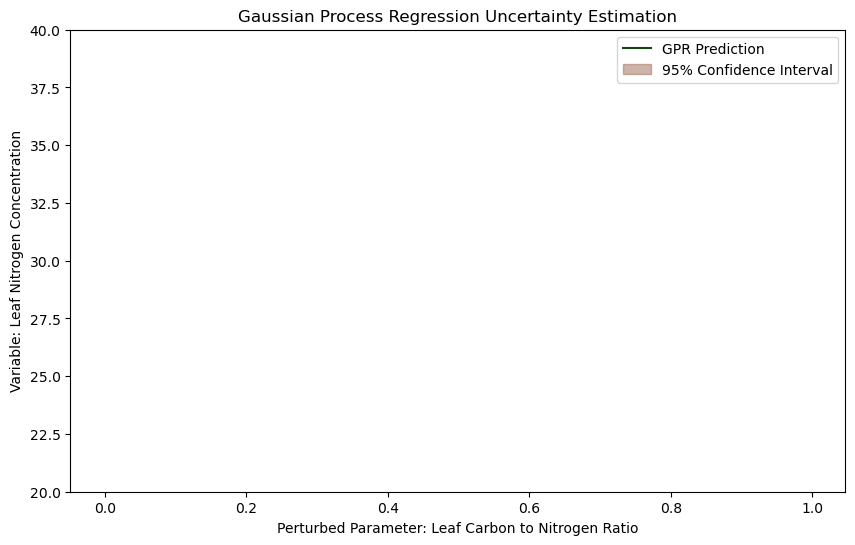

In [15]:
emulation = train_emulator(param, var)

In [ ]:
emulation

#### Changing the kernel configurations without implementing Linnia's notes

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from scipy.optimize import minimize

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    kernel specifications     ----  
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# defining kernels
linear = ConstantKernel(constant_value=3.0, constant_value_bounds=(1e-2, 1e4)) \
         * Linear

poly = ConstantKernel(constant_value= 3, constant_value_bounds=(1e-2, 1e4)) \
        * Polynomial 

# RBF kernel in GPflow is equivalent to scikit-learn's RBF kernel
RBF = RBF(length_scale=np.full((1,32)),length_scale_bounds=(1e-4, 1e8))

# Matern32 in GPflow is equivalent to scikit-learn's Matern with nu=1.5
Matern32 = ConstantKernel(constant_value= 3, constant_value_bounds=(1e-2, 1e4)) * Matern(length_scale=1, nu=1.5)

# Matern52 in GPflow is equivalent to scikit-learn's Matern with nu=2.5
Matern52 = ConstantKernel(constant_value= 3, constant_value_bounds=(1e-2, 1e4)) * Matern(length_scale=1, nu=2.5)

# Bias kernel in GPflow is equivalent to scikit-learn's WhiteKernel
bias = WhiteKernel(noise_level= 3, noise_level_bounds=(1e-2, 1e4))

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    kernel specifications     ----  
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# defining kernels
linear = ConstantKernel(constant_value=3.0, constant_value_bounds=(1e-2, 1e4)) \
         * Linear

poly = ConstantKernel(constant_value= 3, constant_value_bounds=(1e-2, 1e4)) \
        * Polynomial 

# RBF kernel in GPflow is equivalent to scikit-learn's RBF kernel
RBF = RBF(length_scale=1,length_scale_bounds=(1e-4, 1e8))

# Matern32 in GPflow is equivalent to scikit-learn's Matern with nu=1.5
Matern32 = ConstantKernel(constant_value= 3, constant_value_bounds=(1e-2, 1e4)) * Matern(length_scale=1, nu=1.5)

# Matern52 in GPflow is equivalent to scikit-learn's Matern with nu=2.5
Matern52 = ConstantKernel(constant_value= 3, constant_value_bounds=(1e-2, 1e4)) * Matern(length_scale=1, nu=2.5)

# Bias kernel in GPflow is equivalent to scikit-learn's WhiteKernel
bias = WhiteKernel(noise_level= 3, noise_level_bounds=(1e-2, 1e4))

In [ ]:
# unable to call any of these objects in my custom kernel chunk
Matern32

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----  custom kernel configuration ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# linnia's trees kernel
kernel_1 = linear + RBF + poly + bias

# linnia's grass kernel
#kernel_2 = linear * RBF + Mater32 + bias 
#kernel_3 = linear * RBF + Matern52 + bias

# test kernels
kernel_4 = linear * RBF + poly + bias
#kernel_5 = linear * RBF + Matern52 + poly + bias

#kernel_6 = linear + RBF + Matern32 + poly + bias
kernel_7 = linear * RBF + bias

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Split Data 90/10        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# data for splitting
X_train, X_test, y_train, y_test = train_test_split(param,
                                                    var,
                                                     test_size=0.2,
                                                     # setting a seed
                                                     random_state=0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    Kernel Specs No Tuning    ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# initiate the model without tuning
kernel = kernel_1

gp_model = GaussianProcessRegressor(kernel=kernel,
                                    n_restarts_optimizer=20,
                                    random_state=42,
                                    #normalize_y = True
                                   )
    
# Scale the normalized target variable y to the desired range
#scaler = MinMaxScaler(feature_range=(20, 40))
#y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Fit the Model        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Fit the model to the training data
gp_model = gp_model.fit(X_train, y_train)

    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Get Predictions      ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Make predictions
y_pred, y_std = gp_model.predict(X_test, return_std=True)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Collect Metrics      ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Verify training score
train_score = gp_model.score(X_train, y_train)

# Calculate R^2
r2_train = r2_score(y_test, y_pred)
# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_test, y_pred))

# Create a DataFrame to store the results for plotting
results_df = pd.DataFrame({
    'y_pred': y_pred,
    'y_std': y_std,
    'y_test': y_test,
    'X_test': [x.tolist() for x in X_test],  # Convert array to list for DataFrame
})

# Add metrics to the DataFrame
results_df['R^2'] = r2_train
results_df['RMSE'] = rmse_train
    
# Print Training Metrics
print("Training Score:", train_score)
print("Training R^2:", r2_train)
print("Training RMSE:", rmse_train)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----        Archive Metrics       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
# Create a directory to store the results if it doesn't exist
results_dir = "emulation_results"
os.makedirs(results_dir, exist_ok=True)

# Save the results DataFrame to a CSV file
# CURRENT FILE NAME IS None_emulation_results
results_file = os.path.join(results_dir, f'{var.name}_emulation_results.csv') # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
results_df.to_csv(results_file, index=False)

    # NEED TO FIX THIS, NOT OUTPUTTING PROPERLY
    # Convert DataFrame to xarray Dataset
    #ds = xr.Dataset.from_dataframe(results_df)

    # Save the results to a NetCDF file
    #nc_file = os.path.join(results_dir, f'{var}_emulation_results.nc')
    #ds.to_netcdf(nc_file)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Visualize Emulation     ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Calculate the z-score for the 99.7% confidence interval
# 99.7th percentile (three standard deviations)
z_score = norm.ppf(0.99865)  
    
# Sort X_test and corresponding predictions for plotting
sorted_indices = np.argsort(X_test[:, 0])
X_test_sorted = X_test[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]
y_std_sorted = y_std[sorted_indices]
    
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(X_test_sorted[:, 0], y_pred_sorted, color='#134611', label='GPR Prediction')
# applying z-score for 99.7% CI
plt.fill_between(X_test_sorted[:, 0], y_pred_sorted - z_score * y_std_sorted, y_pred_sorted + z_score * y_std_sorted, alpha=0.5, color='#9d6b53', label = '95% Confidence Interval')
plt.xlabel('Perturbed Parameter: Leaf Carbon to Nitrogen Ratio')
plt.ylabel('Variable: Leaf Nitrogen Concentration')
plt.title('Gaussian Process Regression Uncertainty Estimation')
plt.legend()
plt.show()

In [ ]:
emulation2 = train_emulator(param, var)

#### Expanding Function to Include Linnia's Notes

##### Error in applying np.tiles(1,32) for RBF length_scale

`RBF.__call__() got an unexpected keyword argument 'length_scale'`

I usually have to restart my kernel after a couple runs because I get this error. I'm stumped on how to go about implementing np.tiles, so we can have a independent length_scale for each parameter. I've checked the documentation and it matches the notation being used. I just don't have a full understanding of all the object types involved, yet.

In [ ]:
# defining length_scale
length_scale = np.tile(1,32)

# defining kernels
linear = ConstantKernel(constant_value=3.0, constant_value_bounds=(1e-2, 1e4)) \
         * Linear

poly = ConstantKernel(constant_value= 3, constant_value_bounds=(1e-2, 1e4)) \
        * Polynomial 

# RBF kernel in GPflow is equivalent to scikit-learn's RBF kernel
RBF = RBF(length_scale=length_scale,
          length_scale_bounds=(1e-4, 1e8))

# Matern32 in GPflow is equivalent to scikit-learn's Matern with nu=1.5
Matern32 = ConstantKernel(constant_value= 3, constant_value_bounds=(1e-2, 1e4)) * Matern(length_scale=np.tile(1,32), nu=1.5)

# Matern52 in GPflow is equivalent to scikit-learn's Matern with nu=2.5
Matern52 = ConstantKernel(constant_value= 3, constant_value_bounds=(1e-2, 1e4)) * Matern(length_scale=np.tile(1,32), nu=2.5)

# Bias kernel in GPflow is equivalent to scikit-learn's WhiteKernel
bias = WhiteKernel(noise_level= 3, noise_level_bounds=(1e-2, 1e4))

# Sujan's configuration: R^2: -0.005, rmse: 0.194
#sujan_kernel = ConstantKernel(constant_value = 3,
 #                           constant_value_bounds=(1e-2, 1e4)) \
  #                * RBF(length_scale=1, 
   #                     length_scale_bounds=(1e-4, 1e8))

#### Error

I think this is happening either because we've normalized y or applied np.tile

`TypeError: loop of ufunc does not support argument 0 of type function which has no callable log method`

In [ ]:
# Define length_scale for RBF kernel
length_scale = np.tile(1, 32)  # Assuming you have 32 features

# Define sklearn kernels
linear = ConstantKernel(constant_value=3.0, constant_value_bounds=(1e-2, 1e4)) * Linear
poly = ConstantKernel(constant_value=3, constant_value_bounds=(1e-2, 1e4)) * Polynomial 
RBF = RBF(length_scale=length_scale, length_scale_bounds=(1e-4, 1e8))
bias = WhiteKernel(noise_level=3, noise_level_bounds=(1e-2, 1e4))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(param, var, test_size=0.2, random_state=0)

# Define the composite kernel
kernel = linear + RBF + poly + bias
#linear + RBF + poly + bias
# linear * RBF + Matern + bias

# Initialize Gaussian Process model
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, random_state=42, normalize_y=True)

# Fit the model to the training data
gp_model.fit(X_train, y_train)

# Make predictions
y_pred = gp_model.predict(X_test)

# Calculate training score
train_score = gp_model.score(X_train, y_train)

# Calculate R^2
r2_train = r2_score(y_test, y_pred)

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_test, y_pred))

# Print Training Metrics
print("Training Score:", train_score)
print("Training R^2:", r2_train)
print("Training RMSE:", rmse_train)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Visualize Emulation     ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Calculate the z-score for the 99.7% confidence interval
# 99.7th percentile (three standard deviations)
z_score = norm.ppf(0.99865)  
    
# Sort X_test and corresponding predictions for plotting
sorted_indices = np.argsort(X_test[:, 0])
X_test_sorted = X_test[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]
y_std_sorted = y_std[sorted_indices]
    
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(X_test_sorted[:, 0], y_pred_sorted, color='#134611', label='GPR Prediction')
# applying z-score for 99.7% CI
plt.fill_between(X_test_sorted[:, 0], y_pred_sorted - z_score * y_std_sorted, y_pred_sorted + z_score * y_std_sorted, alpha=0.5, color='#9d6b53', label = '95% Confidence Interval')
plt.xlabel('Perturbed Parameter: Leaf Carbon to Nitrogen Ratio')
plt.ylabel('Variable: Leaf Nitrogen Concentration')
plt.title('Gaussian Process Regression Uncertainty Estimation')
plt.legend()
plt.show()

In [ ]:
# Get the number of dimensions
n_dims = RBF.n_dims
n_dims

#### Error at gp_model.fit(X_train, y_train)
`TypeError: loop of ufunc does not support argument 0 of type function which has no callable log method`

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(param, var, test_size=0.2, random_state=0)

# Define the composite kernel
kernel = linear * RBF + Matern + bias

# Initialize Gaussian Process model
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, random_state=42, normalize_y=True)

# Fit the model to the training data
gp_model.fit(X_train, y_train)

# Make predictions
y_pred = gp_model.predict(X_test)

# Calculate training score
train_score = gp_model.score(X_train, y_train)

# Calculate R^2
r2_train = r2_score(y_test, y_pred)

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_test, y_pred))

# Print Training Metrics
print("Training Score:", train_score)
print("Training R^2:", r2_train)
print("Training RMSE:", rmse_train)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Visualize Emulation     ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Calculate the z-score for the 99.7% confidence interval
# 99.7th percentile (three standard deviations)
z_score = norm.ppf(0.99865)  
    
# Sort X_test and corresponding predictions for plotting
sorted_indices = np.argsort(X_test[:, 0])
X_test_sorted = X_test[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]
y_std_sorted = y_std[sorted_indices]
    
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(X_test_sorted[:, 0], y_pred_sorted, color='#134611', label='GPR Prediction')
# applying z-score for 99.7% CI
plt.fill_between(X_test_sorted[:, 0], y_pred_sorted - z_score * y_std_sorted, y_pred_sorted + z_score * y_std_sorted, alpha=0.5, color='#9d6b53', label = '95% Confidence Interval')
plt.xlabel('Perturbed Parameter: Leaf Carbon to Nitrogen Ratio')
plt.ylabel('Variable: Leaf Nitrogen Concentration')
plt.title('Gaussian Process Regression Uncertainty Estimation')
plt.legend()
plt.show()

#### Apply Optimization

Output says:
Best hyperparameters: {'length_scale': 79654298.68805788, 'noise_level': 1834.3560643137396}

Going to apply this to our working function and see how it improves -- it does not improve

In [ ]:
# Import necessary libraries
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define the objective function
@use_named_args([
    Real(1e-2, 1e8, name='length_scale'),
    Real(1e-2, 1e4, name='noise_level')
])
def objective(length_scale, noise_level):
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Split Data 90/10        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # data for splitting
    X_train, X_test, y_train, y_test = train_test_split(param,
                                                        var,
                                                        test_size=0.2,
                                                        # setting a seed
                                                        random_state=0)

    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Kernel Specs No Tuning    ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Define the kernel with the current hyperparameters
    kernel = ConstantKernel(constant_value=3.0, constant_value_bounds=(1e-2, 1e4)) * RBF(length_scale=length_scale) + WhiteKernel(noise_level=noise_level)
    
    # Initialize Gaussian Process model
    gp_model = GaussianProcessRegressor(kernel=kernel, random_state=42, normalize_y=True)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Fit the Model        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Fit the model to the training data
    gp_model.fit(X_train, y_train)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Get Predictions      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Evaluate the model using mean squared error
    y_pred = gp_model.predict(X_test)
    loss = mean_squared_error(y_test, y_pred)
    
    # Return the negative of the loss since gp_minimize seeks to minimize the function
    return loss


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----       Apply Optimization     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define the search space
search = [
    Real(1e-2, 1e8, name='length_scale'),
    Real(1e-2, 1e4, name='noise_level')
]

# Perform Bayesian optimization
result = gp_minimize(objective, search, n_calls=20, random_state=42)

# Extract the best hyperparameters
best_params = dict(zip(['length_scale', 'noise_level'], result.x))
print("Best hyperparameters:", best_params)

#### Applying the length_scale from above worsened our model

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def train_emulator(param, var):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Split Data 90/10        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # data for splitting
    X_train, X_test, y_train, y_test = train_test_split(param, 
                                                        var,
                                                        test_size=0.2,
                                                        # setting a seed
                                                        random_state=0)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Kernel Specs No Tuning    ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # initiate the model without tuning
    kernel = ConstantKernel(constant_value = 3,
                            constant_value_bounds=(1e-2, 1e4)) \
                  * RBF(length_scale=79654298.68805788, 
                        length_scale_bounds=(1e-4, 1e8))

    gp_model = GaussianProcessRegressor(kernel=kernel,
                                        n_restarts_optimizer=20,
                                        random_state=42,
                                        normalize_y=True)

    # Scale the normalized target variable y to the desired range
    scaler = MinMaxScaler(feature_range=(20, 40))
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Fit the Model        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Fit the model to the training data
    gp_model = gp_model.fit(X_train, y_train_scaled)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Get Predictions      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Make predictions
    y_pred, y_std = gp_model.predict(X_test, return_std=True)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Collect Metrics      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Verify training score
    train_score = gp_model.score(X_train, y_train)

    # Calculate R^2
    r2_train = r2_score(y_test, y_pred)
    # Calculate RMSE
    rmse_train = np.sqrt(mean_squared_error(y_test, y_pred))

    # Create a DataFrame to store the results for plotting
    results_df = pd.DataFrame({
        'y_pred': y_pred,
        'y_std': y_std,
        'y_test': y_test,
        'X_test': [x.tolist() for x in X_test],  # Convert array to list for DataFrame
    })

    # Add metrics to the DataFrame
    results_df['R^2'] = r2_train
    results_df['RMSE'] = rmse_train
    
    # Print Training Metrics
    print("Training Score:", train_score)
    print("Training R^2:", r2_train)
    print("Training RMSE:", rmse_train)

    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Visualize Emulation     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Calculate the z-score for the 99.7% confidence interval
    # 99.7th percentile (three standard deviations)
    z_score = norm.ppf(0.99865)  
    
    # Sort X_test and corresponding predictions for plotting
    sorted_indices = np.argsort(X_test[:, 0])
    X_test_sorted = X_test[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]
    y_std_sorted = y_std[sorted_indices]
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(X_test_sorted[:, 0], y_pred_sorted, color='#134611', label='GPR Prediction')
    # applying z-score for 99.7% CI
    plt.fill_between(X_test_sorted[:, 0], y_pred_sorted - z_score * y_std_sorted, y_pred_sorted + z_score * y_std_sorted, alpha=0.5, color='#9d6b53', label = '95% Confidence Interval')
    plt.xlabel('Perturbed Parameter: Leaf Carbon to Nitrogen Ratio')
    plt.ylabel('Variable: Leaf Nitrogen Concentration')
    plt.title('Gaussian Process Regression Uncertainty Estimation')
    plt.legend()
    plt.show()

    return results_df

In [ ]:
emulation = train_emulator(param, var)

#### Using product and sum to combine kernels, but I don't think this is necessary

In [ ]:
from sklearn.gaussian_process.kernels import Sum, Product

n_features = param.shape
n_features = n_features.reshape(-1,-1)

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Split Data 90/10        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# data for splitting
X_train, X_test, y_train, y_test = train_test_split(param,
                                                    var,
                                                    test_size=0.2,
                                                    # setting a seed
                                                    random_state=0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    Kernel Specs No Tuning    ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# initiate the model without tuning
#linear + RBF + poly + bias

# Create the product of linear and rbf kernels
kernel_product = Product(linear, rbf)

# Sum the product kernel with the bias kernel
kernel = Sum(kernel_product, bias)


gp_model = GaussianProcessRegressor(kernel=kernel,
                                    n_restarts_optimizer=20,
                                    random_state=42,
                                    normalize_y = True)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Fit the Model        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Fit the model to the training data
gp_model = gp_model.fit(X_train, y_train)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Get Predictions      ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Make predictions
y_pred = gp_model.predict(X_test)
    

# Verify training score
train_score = gp_model.score(X_train, y_train)

# Calculate R^2
r2_train = r2_score(y_test, y_pred)
# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_test, y_pred))

# Print Training Metrics
print("Training Score:", train_score)
print("Training R^2:", r2_train)
print("Training RMSE:", rmse_train)

In [ ]:
train_emulator(param, var)